# COVID-19 data analysis

In [1]:
#keep repository update
!git pull https://github.com/pcm-dpc/COVID-19.git master --no-edit

From https://github.com/pcm-dpc/COVID-19
 * branch            master     -> FETCH_HEAD
Already up-to-date.


In [2]:
#libraries
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import os
import numpy as np
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
import datetime
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
plt.style.use('ggplot')

In [3]:
#remove annoying worning about pandas assignment
pd.options.mode.chained_assignment = None

In [4]:
from sklearn.linear_model import LinearRegression,HuberRegressor,Ridge
lr = LinearRegression()

# Load national dataset

In [5]:
df = pd.read_csv(os.path.join('dati-andamento-nazionale',
                               'dpc-covid19-ita-andamento-nazionale.csv'))
df.data = pd.to_datetime(df.data)
df['terapia_intensiva_change']=df['terapia_intensiva']-df['terapia_intensiva'].shift(1)
df['deceduti_change']=df['deceduti']-df['deceduti'].shift(1)
df['not_admitted_ratio'] = df['deceduti_change']/(df['terapia_intensiva_change'])
df['not_admitted'] = df['deceduti_change']-(df['terapia_intensiva_change'])
df.drop(['stato'],axis=1,inplace=True)
df.drop(['data'],axis=1).tail()

yR='nuovi_attualmente_positivi'
df[yR+'_log']=np.log10(df[yR])

yR='deceduti_change'
df[yR+'_log']=np.log10(df[yR])

yR='terapia_intensiva'
df[yR+'_log']=np.log10(df[yR])

## Fig1

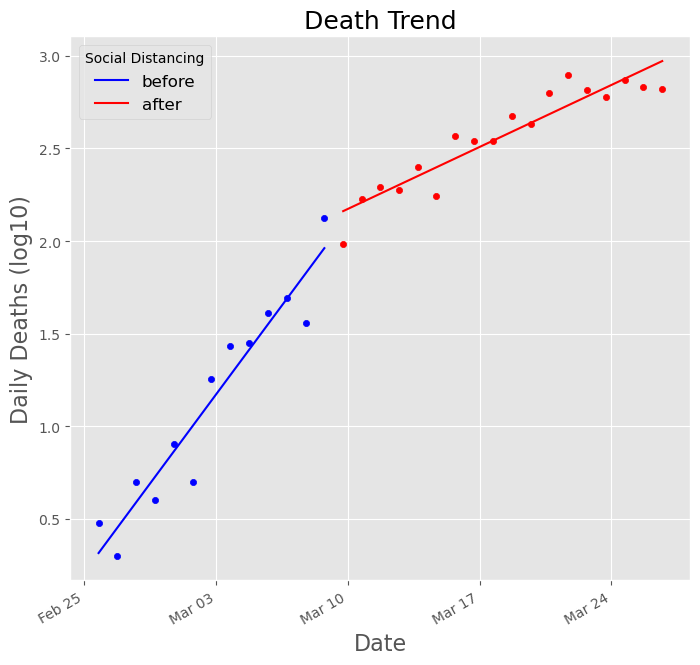

In [10]:
yR='deceduti_change'
df=df[~df[yR+'_log'].isna()]
before = df[df['data']<'2020-03-9']
after = df[df['data']>'2020-03-9']
plt.style.use('ggplot')
fig,ax=plt.subplots(figsize=(8,8))

before.plot(x='data',
         y=yR+'_log',
         kind='scatter',ax=ax,c='b')

after.plot(x='data',
         y=yR+'_log',
         kind='scatter',ax=ax,c='r')

x=before['data'].values.reshape(-1, 1)
y=before[yR+'_log'].values
lr.fit(x,y)
#plt.plot(x, lr.predict(x), 'b-')
y_pred = lr.predict(before.data.values.astype(float).reshape(-1, 1))
before.loc[:,'y_pred']=y_pred

before.plot(x='data',
         y='y_pred',
         ax=ax,c='b',label='before')

x=after['data'].values.reshape(-1, 1)
y=after[yR+'_log'].values
lr.fit(x,y )
#plt.plot(x, lr.predict(x), 'b-')
y_pred = lr.predict(after.data.values.astype(float).reshape(-1, 1))
after.loc[:,'y_pred']=y_pred

after.plot(x='data',
         y='y_pred',
         ax=ax,c='r',label='after')
plt.legend(title='Social Distancing',fontsize=12)

#set ticks every week
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
#set major ticks format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))



#plt.xticks(rotation=70,ha='right')
plt.xlabel('Date', fontsize='16')
plt.ylabel('Daily Deaths (log10)',fontsize='16')
plt.title('Death Trend',fontsize='18')
plt.savefig('Fig1.png')

## Fig2

In [7]:
#x.min()

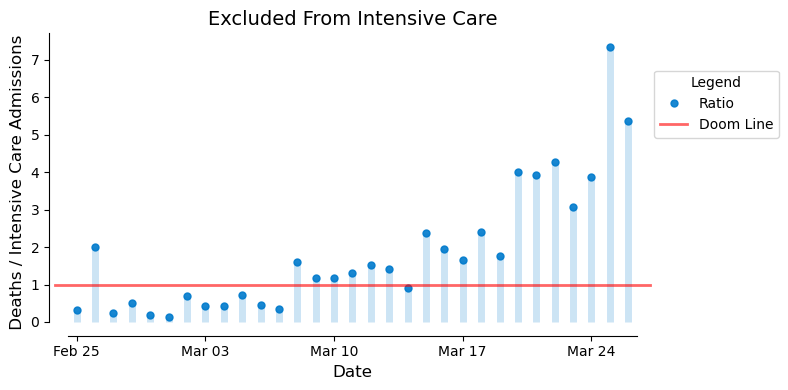

In [8]:

plt.style.use('default')
#df['data']=df['data'].dt.to_period('D')

fig,ax=plt.subplots(figsize=(8,4))
ax.plot(df['data'].dt.date, df['not_admitted_ratio'], "o", markersize=5, color='#007acc', alpha=0.9,label='Ratio')
ax.vlines(x=df['data'].dt.date, ymin=0, ymax=df['not_admitted_ratio'], color='#007acc', alpha=0.2, linewidth=5)

#set ticks every week
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
#set major ticks format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
designdate='March 08 2020 13:00'
#ax.axvline(pd.to_datetime(designdate), ymin=0.1,ymax=0.9,linewidth=2)

xtickslocs = ax.get_xticks()
xmin, xmax = ax.get_xlim()

ax.axhline(1, xmin=0.01,xmax=0.99,
           linewidth=2,color='r',alpha=0.6,label='Doom Line')

ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')

ymin, ymax = ax.get_ylim()
ax.spines['left'].set_bounds(0, ymax)


xmin, xmax = ax.get_xlim()
ax.spines['bottom'].set_bounds(xmin+1, xmax-1)

plt.xlabel('Date', fontsize='12')
plt.ylabel(' Deaths / Intensive Care Admissions', fontsize='12')
plt.title('Excluded From Intensive Care', fontsize='14')

plt.legend(loc='upper center', bbox_to_anchor=(1.1, 0.9), title='Legend')
plt.tight_layout()
plt.savefig('Fig2.png')
plt.show()

## Fig3

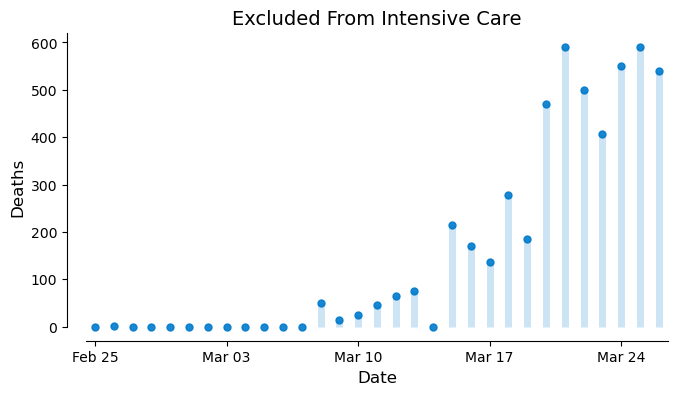

In [9]:
import datetime
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
plt.style.use('default')
#df['data']=df['data'].dt.to_period('D')

fig,ax=plt.subplots(figsize=(8,4))
ax.plot(df['data'].dt.date, df['not_admitted'].clip(lower=0),
        "o", markersize=5, color='#007acc', alpha=0.9,label='Ratio')
ax.vlines(x=df['data'].dt.date, ymin=0, ymax=df['not_admitted'].clip(lower=0), 
          color='#007acc', alpha=0.2, linewidth=5)

#set ticks every week
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
#set major ticks format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
designdate='March 08 2020 13:00'
#ax.axvline(pd.to_datetime(designdate), ymin=0.1,ymax=0.9,linewidth=2)

xtickslocs = ax.get_xticks()
xmin, xmax = ax.get_xlim()


ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
#ax.spines['left'].set_smart_bounds(True)
#ax.spines['bottom'].set_smart_bounds(True)
ymin, ymax = ax.get_ylim()
ax.spines['left'].set_bounds(0, ymax)


xmin, xmax = ax.get_xlim()
ax.spines['bottom'].set_bounds(xmin+1, xmax-1)

plt.xlabel('Date', fontsize='12')
plt.ylabel('Deaths', fontsize='12')
plt.title('Excluded From Intensive Care', fontsize='14')

#plt.legend(loc='upper center', bbox_to_anchor=(1.1, 0.9), title='Legend')
plt.savefig('Fig3.png')
plt.show()

In [ ]:
!jupyter nbconvert --to html_toc DataVis.ipynb

In [ ]:
!git add DataVis*
!git add -u
!git commit -m 'add toc to notebook'
!git push -u origin master